# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [30]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  4784k      0  0:00:01  0:00:01 --:--:-- 4784k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1556k      0  0:00:01  0:00:01 --:--:-- 1556k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  4136k      0  0:00:01  0:00:01 --:--:-- 4134k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  1225k      0  0:00:01  0:00:01 --:--:-- 1225k


In [31]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [34]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [35]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [36]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2909.28it/s]

0.0


#Q1

You should create one block for each question

In [61]:
"""
Question 1
Implement the following four (non-personalised) baselines for ranking books based on their statistics:
● Average rating, obtained from ratings.csv
● Number of ratings, obtained from books.csv (column ratings_count)
12/2/2020 v1.0 3
● Number of 5* ratings, obtained from books.csv
● Fraction of 5* ratings, calculated from the two evidence above.
Evaluate these in terms of the MRR metric using the provided test data.
"""
import matplotlib.pyplot as plt

class baselineModel:
  def __init__(self, metric):
    self.predictions=metric

  def predict(self, uid):
    return( self.predictions )

average = ratings_df.groupby(['book_id']).mean()
#print("Average: ",average)
averageRatings = average['rating'].to_numpy()
#print("Average Rating: ",averageRatings)

#sortedAvgRatingsDes = np.sort(averageRatings)[::-1]
#sortedAvgRatingsAsc = np.sort(averageRatings)

r1 = mrr_score(baselineModel(averageRatings), test_dataset, train=rating_dataset, k=100).mean()
print("1. MRR Score Average Rating:\n",r1)
#print("1. MRR Score Des: ",mrr_score(baselineModel(sortedAvgRatingsDes), test_dataset, train=rating_dataset, k=100).mean())
#print("1. MRR Score Asc: ",mrr_score(baselineModel(sortedAvgRatingsAsc), test_dataset, train=rating_dataset, k=100).mean())


number_ratings = books_df["ratings_count"].to_numpy()
sortedNumbRatingsDes = np.sort(number_ratings)[::-1]

r2 = mrr_score(baselineModel(number_ratings), test_dataset, train=rating_dataset, k=100).mean()
print("\n2. MRR Score Number Ratings:\n",r2)
#print("2. MRR Score Des: ",mrr_score(baselineModel(sortedNumbRatingsDes), test_dataset, train=rating_dataset, k=100).mean())
#print("TYPES: ",type(averageRatings),type(number_ratings))


number_5_ratings = books_df["ratings_5"].to_numpy()
#sorted5starRatingsDes = np.sort(number_5_ratings)[::-1]

r3 = mrr_score(baselineModel(number_5_ratings), test_dataset, train=rating_dataset, k=100).mean()
print("\n3. MRR Score Number 5 Ratings:\n",r3)
#print("3. MRR Score Des: ",mrr_score(baselineModel(sorted5starRatingsDes), test_dataset, train=rating_dataset, k=100).mean())


fraction_5_ratings = number_5_ratings/number_ratings
#sorted5starFracRatingsDes = np.sort(fraction_5_ratings)[::-1]

r4 = mrr_score(baselineModel(fraction_5_ratings), test_dataset, train=rating_dataset, k=100).mean()
print("\n4. MRR Score Fraction 5 Ratings:\n",r4)
#print("4. MRR Score Des: ",mrr_score(baselineModel(sorted5starFracRatingsDes), test_dataset, train=rating_dataset, k=100).mean())


'''
RESULTS:
1. MRR Score Average Rating:  0.024775365599441497

2. MRR Score Number Ratings:  0.008181375050318986

3. MRR Score Number 5 Ratings:  0.008070258646211246

4. MRR Score Fraction 5 Ratings:  0.03138372904213526
'''



'''
#Length 135615
print(toread_dataset)
print(toread_iids)
print(toread_uids)

#Length 33917
print(test_dataset)
print(test_iids)
print(test_uids)

#Length 124762
print(rating_dataset)
print(rating_iids)
print(rating_uids)
'''
#get_average_rating(5)

'''
x = dataset.user_ids==8
ratingX = dataset.ratings[x]
print(len(ratingX))
'''

1. MRR Score Average Rating:
 0.024775365599441497

2. MRR Score Number Ratings:
 0.008181375050318986

3. MRR Score Number 5 Ratings:
 0.008070258646211246

4. MRR Score Fraction 5 Ratings:
 0.03138372904213526


'\nx = dataset.user_ids==8\nratingX = dataset.ratings[x]\nprint(len(ratingX))\n'

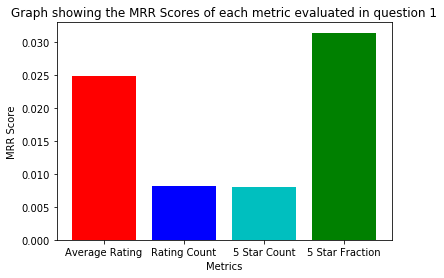

In [38]:
results=[r1,r2,r3,r4]
x = [1,2,3,4]
labels = ['Average Rating','Rating Count','5 Star Count','5 Star Fraction']

fig, ax = plt.subplots()
plt.title("Graph showing the MRR Scores of each metric evaluated in question 1")
ax.bar(x,results,color=['r','b','c','g'],label=labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel('Metrics')
plt.ylabel('MRR Score')

plt.show()

In [39]:
'''
Question 2
From Spotlight, use ExplicitFactorizationModel and ImplicitFactorizationModel (the
latter using the BPR loss function) to train recommendation models based on the explicit ratings
(ratings.csv). For both models, use 5 iterations of training. For the most effective approach, tune
the number of latent factors in the range [8,16,32,64] using the validation set to maximise MRR.
Evaluate the best model in terms of MRR using the provided test data.
'''
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel

#We define the validation set 
train_dataset, validation_data = random_train_test_split(rating_dataset, random_state=np.random.RandomState(42))
#toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.seed(42))

print("TRAIN EXP: ",train_dataset)
print("VALIDATION EXP: ",validation_data)

print("TRAIN IMP: ",toread_dataset_train)
print("VALIDATION IMP: ",validation)

print("TEST: ",test_dataset)



latentF = [8,16,32,64]
resultsImpModel = []
resultsExpModel = []
#We do not use implicit data for this task (only required in question 3)
for factor in latentF:
  modelExp = ExplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), embedding_dim=factor)#,learning_rate=learning_rate,random_state= seed)
  modelImp = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), embedding_dim=factor,loss='bpr')

  modelExp.fit(train_dataset)
  modelImp.fit(train_dataset)

  r1 = mrr_score(modelExp, validation_data).mean()
  r2 = mrr_score(modelImp, validation_data).mean()
  print("\nMRR Score Explicit for {} factors: {}".format(factor,r1))#, train=train_dataset).mean())
  print("MRR Score Implicit for {} factors: {}".format(factor,r2))#, train=train_dataset).mean())
  resultsExpModel += [r1]
  resultsImpModel += [r2]


print(resultsImpModel)
print(resultsExpModel)
'''
VALIDATION RESULTS (MRR SCORES):

MRR Score Explicit for 8 factors: 0.02405349500146899
MRR Score Implicit for 8 factors: 0.1891693862804418

MRR Score Explicit for 16 factors: 0.022389170775864123
MRR Score Implicit for 16 factors: 0.19914659710807783

MRR Score Explicit for 32 factors: 0.03295219038090474
MRR Score Implicit for 32 factors: 0.19726073354137386

MRR Score Explicit for 64 factors: 0.029635651158912788
MRR Score Implicit for 64 factors: 0.16964355193469752
'''



TRAIN EXP:  <Interactions dataset (1999 users x 1826 items x 99809 interactions)>
VALIDATION EXP:  <Interactions dataset (1999 users x 1826 items x 24953 interactions)>
TRAIN IMP:  <Interactions dataset (1999 users x 1826 items x 108492 interactions)>
VALIDATION IMP:  <Interactions dataset (1999 users x 1826 items x 27123 interactions)>
TEST:  <Interactions dataset (1999 users x 1826 items x 33917 interactions)>

MRR Score Explicit for 8 factors: 0.02405349500146899
MRR Score Implicit for 8 factors: 0.1891693862804418

MRR Score Explicit for 16 factors: 0.022389170775864123
MRR Score Implicit for 16 factors: 0.19914659710807783

MRR Score Explicit for 32 factors: 0.03295219038090474
MRR Score Implicit for 32 factors: 0.19726073354137386

MRR Score Explicit for 64 factors: 0.029635651158912788
MRR Score Implicit for 64 factors: 0.16964355193469752
[0.1891693862804418, 0.19914659710807783, 0.19726073354137386, 0.16964355193469752]
[0.02405349500146899, 0.022389170775864123, 0.03295219038

'\nVALIDATION RESULTS (MRR SCORES):\n\nMRR Score Explicit for 8 factors: 0.02405349500146899\nMRR Score Implicit for 8 factors: 0.1891693862804418\n\nMRR Score Explicit for 16 factors: 0.022389170775864123\nMRR Score Implicit for 16 factors: 0.19914659710807783\n\nMRR Score Explicit for 32 factors: 0.03295219038090474\nMRR Score Implicit for 32 factors: 0.19726073354137386\n\nMRR Score Explicit for 64 factors: 0.029635651158912788\nMRR Score Implicit for 64 factors: 0.16964355193469752\n'

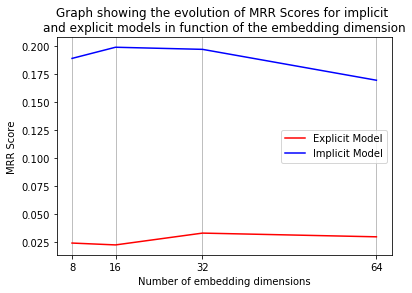

In [40]:
fig, ax = plt.subplots()
plt.title("Graph showing the evolution of MRR Scores for implicit \nand explicit models in function of the embedding dimension")
plt.plot(latentF,resultsExpModel,c='r',label='Explicit Model')
plt.plot(latentF,resultsImpModel,c='b',label='Implicit Model')

ax.set_xticks(latentF)
#ax.set_xticklabels(labels)
plt.xlabel('Number of embedding dimensions')
plt.ylabel('MRR Score')
plt.grid(axis='x')

plt.legend()
plt.show()

In [41]:
#Using the validation set, we obtained the best MRR Score results with 16 latent factors for the implicit model (when the training set is not specified).
bestModelOne = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), embedding_dim=16,loss='bpr')
bestModelOne.fit(train_dataset)
bestScoreQ2 = mrr_score(bestModelOne, test_dataset, train=train_dataset).mean()
print("MRR Score Implicit for {} factors: {}".format(16,bestScoreQ2))
'''
RESULTS:
MRR Score Implicit for 16 factors: 0.3276965863884323
'''

MRR Score Implicit for 16 factors: 0.3276965863884323


'\nRESULTS:\nMRR Score Implicit for 16 factors: 0.3276965863884323\n'

In [42]:
'''
Question 3
Use Spotlight's ImplicitFactorizationModel - with the BPR loss function - on the implicit training
data. Use 5 iterations of training. Tune the number of latent factors in the range [8,16,32,64] using the
validation set to maximise MRR. Evaluate the final model in terms of MRR using the provided test data.
Provide examples of userids for which the system attained the highest RR score. Analyse your findings
(e.g. what did they previously shelf, and what did they then add to their shelf?).
For the implicit factorisation model, implement the Intra-list diversity measure (see Lecture 12) of the
top 5 scored items based on their item embeddings. Identify, compare & contrast the suggested items
for users that have high and low Intra-list diversity scores.
'''

latentFactors = [8,16,32,64]
resultsQ3 = []
#Now we use the implicit data
for LF in latentFactors:
  modelImp = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), embedding_dim=LF,loss='bpr')
  modelImp.fit(toread_dataset_train)
  r3 = mrr_score(modelImp, validation).mean()
  print("LF is ",LF," - MRR Score:\n",r3)#, train=toread_dataset_train).mean())
  resultsQ3 += [r3]

print(resultsQ3)
'''
RESULTS:
LF is  8  - MRR Score:  0.1931247369716604
LF is  16  - MRR Score:  0.2031210049469179
LF is  32  - MRR Score:  0.1910659694926828
LF is  64  - MRR Score:  0.17840289192215153
'''


LF is  8  - MRR Score:
 0.1931247369716604
LF is  16  - MRR Score:
 0.2031210049469179
LF is  32  - MRR Score:
 0.1910659694926828
LF is  64  - MRR Score:
 0.17840289192215153
[0.1931247369716604, 0.2031210049469179, 0.1910659694926828, 0.17840289192215153]


'\nRESULTS:\nLF is  8  - MRR Score:  0.1931247369716604\nLF is  16  - MRR Score:  0.2031210049469179\nLF is  32  - MRR Score:  0.1910659694926828\nLF is  64  - MRR Score:  0.17840289192215153\n'

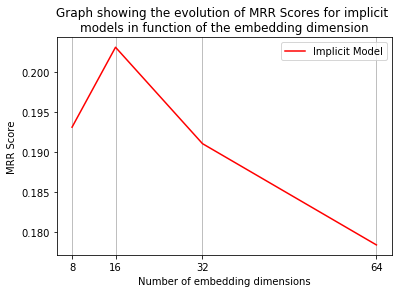

In [43]:
fig, ax = plt.subplots()
plt.title("Graph showing the evolution of MRR Scores for implicit \nmodels in function of the embedding dimension")
plt.plot(latentF,resultsQ3,c='r',label='Implicit Model')

ax.set_xticks(latentF)
#ax.set_xticklabels(labels)
plt.xlabel('Number of embedding dimensions')
plt.ylabel('MRR Score')
plt.grid(axis='x')

plt.legend()
plt.show()

In [44]:
#We take our best result 
bestModelTwo = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1), embedding_dim=16,loss='bpr')
bestModelTwo.fit(toread_dataset_train)
print("Best Result: ",mrr_score(bestModelTwo, test_dataset,train=toread_dataset_train).mean())
'''
RESULTS:
Best Result:  0.3376630775705313
'''

Best Result:  0.3376630775705313


'\nRESULTS:\nBest Result:  0.3376630775705313\n'

In [0]:
import operator
bestRRScores = mrr_score(modelImp, test_dataset)#, train=train_dataset)
topIds = np.argwhere(bestRRScores==np.amax(bestRRScores))

nUsers = 200
# Creating 1D array from 2D array of top user IDs
topUsers = topIds[:nUsers]
bestUsers = []

for arr in topUsers:
  for ID in arr:
    bestUsers += [ID]

#print(bestUsers)
allBooksRead = {}
allBooksShelvedNotRead = {}

for ID in bestUsers:

  #ratings_df[(ratings_df['user_id']==uid) & (ratings_df['rating']>=4)]['book_id'])
  #print(type(ratings_df['user_id']))
  #print(type(ID))
  booksRead = list(ratings_df[(ratings_df['user_id']==ID)]['book_id'])
  booksShelved = list(to_read_df[(to_read_df['user_id']==ID)]['book_id'])
  booksShelvedNotRead = []

  for bookID in booksRead:
    if bookID in allBooksRead:
      allBooksRead[bookID] += 1
    else:
      allBooksRead[bookID] = 1

  for bookID in booksShelved:
    if bookID not in booksRead:
      booksShelvedNotRead += [bookID]

  for bookID in booksShelvedNotRead:
    if bookID in allBooksShelvedNotRead:
      allBooksShelvedNotRead[bookID] += 1
    else:
      allBooksShelvedNotRead[bookID] = 1

  #print(len(booksRead))
  #print(len(booksShelved))
  #print(booksShelvedNotRead,"\n")



In [46]:
def getDictTopCounts(countDict):

  listCounts = []
  listIds = []
  for key in countDict:
    listCounts += [countDict[key]]
    listIds += [key]

  sortedListCounts = np.argsort(listCounts)[-5:][::-1]
  topTenBooksRead = []
  topTenBooksReadCounts = []

  for index in sortedListCounts:
    topTenBooksRead += [listIds[index]]
    topTenBooksReadCounts += [listCounts[index]]

  return topTenBooksRead,topTenBooksReadCounts

topListIdsRead,topListCountsRead = getDictTopCounts(allBooksRead)
topListIdsShelved,topListCountsShelved = getDictTopCounts(allBooksShelvedNotRead)

print("The most read books among the top {} users with the highest RR Scores are:".format(nUsers))
for i in range(len(topListIdsRead)):
  ID = topListIdsRead[i]
  count = topListCountsRead[i]
  print([books_df[books_df['book_id']==ID]['original_title'].to_numpy()[0]],"was read ",count," times")

print("\nThe most shelved books that have not been read among the top {} users with the highest RR Scores are:".format(nUsers))
for i in range(len(topListIdsShelved)):
  ID = topListIdsShelved[i]
  count = topListCountsShelved[i]
  print([books_df[books_df['book_id']==ID]['original_title'].to_numpy()[0]],"was shelved but not read ",count," times")


# print(topListIdsRead)
# print(topListCountsRead)
# print(topListIdsShelved)
# print(topListCountsShelved)

# print(books_df.columns)
'''
test = np.sort(sortedScores)
test2 = np.sort(toread_uids)
print(test)
print(test2)
'''
'''
best_uids = []
for i in range(bestRRScores)
  print(score)
'''
'''
#User IDs start at 0 so they are the same as the array index
for ID in top5users:
  print("User Index: ",ID," - RR Score: ",bestRRScores[ID])
#print(len(bestRRScores))
'''


The most read books among the top 200 users with the highest RR Scores are:
['The Great Gatsby'] was read  48  times
['The Catcher in the Rye'] was read  47  times
['The Hunger Games'] was read  45  times
['To Kill a Mockingbird'] was read  44  times
['Harry Potter and the Chamber of Secrets'] was read  44  times

The most shelved books that have not been read among the top 200 users with the highest RR Scores are:
['The Book Thief'] was shelved but not read  6  times
['The Pillars of the Earth'] was shelved but not read  6  times
['The Glass Castle'] was shelved but not read  6  times
['A Tree Grows In Brooklyn '] was shelved but not read  5  times
["A People's History of the United States: 1492 to Present "] was shelved but not read  5  times


'\n#User IDs start at 0 so they are the same as the array index\nfor ID in top5users:\n  print("User Index: ",ID," - RR Score: ",bestRRScores[ID])\n#print(len(bestRRScores))\n'

In [0]:

import torch.nn.functional as Func

def intraDiv(itemEmbeddings):
  lengthItems = len(itemEmbeddings)
  intraDiv = 0.0
  for i in range(lengthItems):
    for j in range(i+1, lengthItems):
      intraDiv += 1- Func.cosine_similarity(itemEmbeddings[i], itemEmbeddings[j], dim=0)
  result=(2 / (lengthItems * (lengthItems-1)) * intraDiv)
  return result

def getTopFivePredictionsIds(userId):
  prediction = modelImp.predict(userId)
  topPreds = np.argsort(prediction)
  topFiveId = topPreds[-5:]
  testRevTop = []
  #Had to find another way to reverse the top 5 ids due to numpy error.
  i=4
  for k in range(len(topFiveId)):
    testRevTop += [topFiveId[i]]
    i -= 1
  #print(testRevTop)
  #topFiveId = topFiveId[::-1]
  return(testRevTop)

def getTopFivePredictionsTitles(userId):
  topFiveId = getTopFivePredictionsIds(userId)
  allTitles = []
  for ID in topFiveId:
    allTitles += [books_df[books_df['book_id']==ID]['original_title'].to_numpy()]
  
  singleTitles = []
  for array in allTitles:
    for title in array:
      singleTitles += [title]
  
  return singleTitles

intraDivMetric = []
for ID in range(len(bestRRScores)):
  topFiveId = getTopFivePredictionsIds(ID)
  '''
  topFivePred = []
  for itemID in reversed(range(5)):
    topFivePred += [prediction[topFiveId[itemID]]]
  '''
  topFiveEmbed = modelImp._net.item_embeddings.weight[topFiveId]
  intraDivMetric += [intraDiv(topFiveEmbed).item()]



In [48]:
print(intraDivMetric)
topIntraDiv = np.argsort(intraDivMetric)
print(topIntraDiv)
topTenIntraDivIds = topIntraDiv[-10:]
bottomTenIntraDivIds = topIntraDiv[:10]
topTenIntraDivIds = topTenIntraDivIds[::-1]

def printTopBottomTen(outputStr, topTen):
  #We use this to count the most common IDs (if any)
  allFoundItemTitles = {}
  if (topTen):
    IntraDivIds = topTenIntraDivIds
  else:
    IntraDivIds = bottomTenIntraDivIds

  for i in range(10):
    predictedTitles = getTopFivePredictionsTitles(IntraDivIds[i])[::-1]
    print(outputStr.format(i+1,intraDivMetric[IntraDivIds[i]],IntraDivIds[i],
                          getTopFivePredictionsIds(IntraDivIds[i])[::-1],
                          predictedTitles))
    for title in predictedTitles:
      if title in allFoundItemTitles:
        allFoundItemTitles[title] += 1
      else:
        allFoundItemTitles[title] = 1
    
  return allFoundItemTitles

def occuredMoreThanOnce(titles):
  occuredMoreThanOnce = {}
  for t in titles:
    if(titles[t]>1):
      occuredMoreThanOnce[t]=titles[t]

  return occuredMoreThanOnce



outputStr = "\nN°{} Top ILD: {} is user {}\n Top predicted items ID: {}\n Top predicted items Titles: {}"
allFoundItemTitles = printTopBottomTen(outputStr,True)
print("Dictionary IDs predicted for top users that occured more than once: {}".format(occuredMoreThanOnce(allFoundItemTitles)))

outputStr = "\nN°{} Bottom ILD: {} is user {}\n Top predicted items ID: {}\n Top predicted items Titles: {}"
allFoundItemTitles2 = printTopBottomTen(outputStr,False)
print("Dictionary IDs predicted for bottom users that occured more than once: {}".format(occuredMoreThanOnce(allFoundItemTitles2)))

'''
  print("N°{} Top ILD: {} is user {} -    N°{} Bottom ILD: {} is user {}".format(i+1,intraDivMetric[topTenIntraDivIds[i]],topTenIntraDivIds[i],
                                                                                 i+1,intraDivMetric[bottomTenIntraDivIds[i]],bottomTenIntraDivIds[i]))
'''

print(len(intraDivMetric))

'''
RESULTS:
N°1 Top ILD: 0.9235219955444336 is user 423
 Top predicted items ID: [584, 1237, 21, 1082, 228]
 Top predicted items Titles: ['The Magicians', 'The Shell Seekers', 'Harry Potter and the Order of the Phoenix', '色彩を持たない多崎つくると、彼の巡礼の年 [Shikisai o motanai Tazaki Tsukuru to, kare no junrei no toshi]', 'The Nanny Diaries']

N°2 Top ILD: 0.9171609282493591 is user 641
 Top predicted items ID: [644, 0, 633, 621, 744]
 Top predicted items Titles: ['Slammed', 'Starship Troopers', "Are You There God? It's Me, Margaret", 'The Power of Now']

N°3 Top ILD: 0.9170010685920715 is user 1298
 Top predicted items ID: [651, 765, 615, 1578, 200]
 Top predicted items Titles: ["Le Fantôme de l'Opéra", 'The Autobiography of Malcolm X', 'This Lullaby', 'Intensity', 'Ten Little Niggers']

N°4 Top ILD: 0.9114052653312683 is user 1204
 Top predicted items ID: [820, 138, 776, 978, 128]
 Top predicted items Titles: ['The Remains of the Day', 'The Scarlet Letter', 'Shadow of Night', 'Steve Jobs']

N°5 Top ILD: 0.8919159173965454 is user 1911
 Top predicted items ID: [1390, 584, 176, 688, 261]
 Top predicted items Titles: ['Eleven on Top', 'The Magicians', 'It', 'Under the Banner of Heaven: A Story of Violent Faith', 'Under the Tuscan Sun']

N°6 Top ILD: 0.8857353329658508 is user 1766
 Top predicted items ID: [499, 108, 0, 225, 1027]
 Top predicted items Titles: ['American Psycho', 'Confessions of a Shopaholic', 'East of Eden  ', 'The Blood of Olympus']

N°7 Top ILD: 0.8809328079223633 is user 1113
 Top predicted items ID: [821, 931, 782, 1702, 1677]
 Top predicted items Titles: ['The Best of Me', 'Not that Kind of Girl', 'The Awakening', 'Next']

N°8 Top ILD: 0.8706499338150024 is user 627
 Top predicted items ID: [950, 729, 581, 1047, 1359]
 Top predicted items Titles: ["I'll Give You the Sun", 'Hyperion', 'Scarlet', 'The One and Only Ivan', "The Serpent's Shadow"]

N°9 Top ILD: 0.8664948344230652 is user 1694
 Top predicted items ID: [1624, 744, 9, 1219, 683]
 Top predicted items Titles: ['La Nausée', 'The Power of Now', 'Angels & Demons ', 'A Bend in the Road']

N°10 Top ILD: 0.8585401773452759 is user 378
 Top predicted items ID: [997, 996, 176, 23, 21]
 Top predicted items Titles: ['The Scarlet Pimpernel', 'Three to Get Deadly', 'It', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Order of the Phoenix']
Dictionary IDs predicted for top users that occured more than once: {584: 2, 21: 2, 0: 2, 744: 2, 176: 2}

N°1 Bottom ILD: 0.19203515350818634 is user 1151
 Top predicted items ID: [25, 81, 52, 108, 16]
 Top predicted items Titles: ['Harry Potter and the Deathly Hallows', 'The Glass Castle', 'Eclipse', 'Confessions of a Shopaholic', 'Män som hatar kvinnor']

N°2 Bottom ILD: 0.19203515350818634 is user 69
 Top predicted items ID: [52, 25, 81, 108, 16]
 Top predicted items Titles: ['Eclipse', 'Harry Potter and the Deathly Hallows', 'The Glass Castle', 'Confessions of a Shopaholic', 'Män som hatar kvinnor']

N°3 Bottom ILD: 0.19379715621471405 is user 454
 Top predicted items ID: [25, 21, 81, 108, 16]
 Top predicted items Titles: ['Harry Potter and the Deathly Hallows', 'Harry Potter and the Order of the Phoenix', 'The Glass Castle', 'Confessions of a Shopaholic', 'Män som hatar kvinnor']

N°4 Bottom ILD: 0.19379718601703644 is user 1402
 Top predicted items ID: [108, 25, 81, 16, 21]
 Top predicted items Titles: ['Confessions of a Shopaholic', 'Harry Potter and the Deathly Hallows', 'The Glass Castle', 'Män som hatar kvinnor', 'Harry Potter and the Order of the Phoenix']

N°5 Bottom ILD: 0.19801636040210724 is user 102
 Top predicted items ID: [52, 97, 108, 23, 21]
 Top predicted items Titles: ['Eclipse', 'Dracula', 'Confessions of a Shopaholic', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Order of the Phoenix']

N°6 Bottom ILD: 0.19801637530326843 is user 1913
 Top predicted items ID: [97, 52, 108, 21, 23]
 Top predicted items Titles: ['Dracula', 'Eclipse', 'Confessions of a Shopaholic', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Chamber of Secrets']

N°7 Bottom ILD: 0.20222239196300507 is user 433
 Top predicted items ID: [33, 24, 52, 143, 21]
 Top predicted items Titles: ['Memoirs of a Geisha', 'Harry Potter and the Goblet of Fire', 'Eclipse', nan, 'Harry Potter and the Order of the Phoenix']

N°8 Bottom ILD: 0.20285511016845703 is user 1460
 Top predicted items ID: [189, 25, 81, 108, 16]
 Top predicted items Titles: ['The Lord of the Rings', 'Harry Potter and the Deathly Hallows', 'The Glass Castle', 'Confessions of a Shopaholic', 'Män som hatar kvinnor']

N°9 Bottom ILD: 0.2029053419828415 is user 283
 Top predicted items ID: [25, 52, 16, 9, 108]
 Top predicted items Titles: ['Harry Potter and the Deathly Hallows', 'Eclipse', 'Män som hatar kvinnor', 'Angels & Demons ', 'Confessions of a Shopaholic']

N°10 Bottom ILD: 0.2038314789533615 is user 156
 Top predicted items ID: [187, 81, 108, 9, 16]
 Top predicted items Titles: ['Uglies', 'The Glass Castle', 'Confessions of a Shopaholic', 'Angels & Demons ', 'Män som hatar kvinnor']
Dictionary IDs predicted for bottom users that occured more than once: {25: 6, 81: 6, 52: 6, 108: 9, 16: 7, 21: 5, 97: 2, 23: 2, 9: 2}
'''

[0.25611838698387146, 0.2566140294075012, 0.25611838698387146, 0.36771175265312195, 0.3882308900356293, 0.2827962338924408, 0.36657121777534485, 0.28201577067375183, 0.28499820828437805, 0.26092594861984253, 0.27810412645339966, 0.2724854648113251, 0.26450076699256897, 0.5216568112373352, 0.2641489505767822, 0.29266366362571716, 0.2686493396759033, 0.48801931738853455, 0.4123946726322174, 0.29780372977256775, 0.35302677750587463, 0.3109157979488373, 0.4165404438972473, 0.2871396541595459, 0.2597021758556366, 0.2970629632472992, 0.4190511703491211, 0.2662559449672699, 0.3026760518550873, 0.2773935794830322, 0.4239368438720703, 0.4485110342502594, 0.20394861698150635, 0.3345203399658203, 0.31794604659080505, 0.289663702249527, 0.25537484884262085, 0.29673466086387634, 0.27501532435417175, 0.31084564328193665, 0.585688054561615, 0.2585584819316864, 0.39429160952568054, 0.4089386463165283, 0.31701475381851196, 0.252306193113327, 0.2565838694572449, 0.23405833542346954, 0.4618253707885742, 

'\nRESULTS:\nN°1 Top ILD: 0.9235219955444336 is user 423\n Top predicted items ID: [584, 1237, 21, 1082, 228]\n Top predicted items Titles: [\'The Magicians\', \'The Shell Seekers\', \'Harry Potter and the Order of the Phoenix\', \'色彩を持たない多崎つくると、彼の巡礼の年 [Shikisai o motanai Tazaki Tsukuru to, kare no junrei no toshi]\', \'The Nanny Diaries\']\n\nN°2 Top ILD: 0.9171609282493591 is user 641\n Top predicted items ID: [644, 0, 633, 621, 744]\n Top predicted items Titles: [\'Slammed\', \'Starship Troopers\', "Are You There God? It\'s Me, Margaret", \'The Power of Now\']\n\nN°3 Top ILD: 0.9170010685920715 is user 1298\n Top predicted items ID: [651, 765, 615, 1578, 200]\n Top predicted items Titles: ["Le Fantôme de l\'Opéra", \'The Autobiography of Malcolm X\', \'This Lullaby\', \'Intensity\', \'Ten Little Niggers\']\n\nN°4 Top ILD: 0.9114052653312683 is user 1204\n Top predicted items ID: [820, 138, 776, 978, 128]\n Top predicted items Titles: [\'The Remains of the Day\', \'The Scarlet Letter

In [49]:
#Different output for report
bottomUsers = occuredMoreThanOnce(allFoundItemTitles2)

for key in bottomUsers:
  print("Title: {} | Count: {}".format(key, bottomUsers[key]))

Title: Pride and Prejudice | Count: 7
Title: Angels & Demons  | Count: 9
Title: Scarlet | Count: 7
Title: The Kite Runner  | Count: 6
Title: The Hobbit or There and Back Again | Count: 8
Title: The Catcher in the Rye | Count: 4
Title: Harry Potter and the Order of the Phoenix | Count: 5
Title: Naked | Count: 2


In [50]:
'''
Question 4
Combine the outputs from the two ImplicitFactorizationModel models created in Question 2 &
Question 3 using an unsupervised (i.e. unweighted) CombSum data fusion method: CombSum
combines rankings based on the sum of their scores. Evaluate the outcome on the test set using MRR.
Plot the before and after RR scores for each user, compared to the best model from Question 2 or
Question 3. State how many users are improved.
'''
import matplotlib.pyplot as plt

#combines rankings from two models
class combSumModel:
  
  def __init__(self, model1, model2):
    self.model1 = model1
    self.model2 = model2 
  
  def predict(self, uid):
    firstModelPred = np.array(self.model1.predict(uid))
    secondModelPred = np.array(self.model2.predict(uid))
    return firstModelPred+secondModelPred

def compareImprovements (scores1, scores2):
  countImprove = 0
  for i in range(len(scores1)):
    if (scores1[i]<scores2[i]):
      countImprove += 1

  return countImprove

#We combine the results from our best implicit models
CSModel = combSumModel(bestModelOne, bestModelTwo)

#We do not specify the training sets as the combsum model's results rely on multiple training sets (explicit and implicit)
#We trained our first best model using explicit data
RRScoresOne = mrr_score(bestModelOne, test_dataset)
#We trained our second best model using implicit data
RRScoresTwo = mrr_score(bestModelTwo, test_dataset)
#We cannot specify training set for combSum
RRScoresCS = mrr_score(CSModel, test_dataset)

print("The RR Scores of {} users have improved from the best model in Q2 to the combSum model".format(compareImprovements(RRScoresOne,RRScoresCS)))
print("The RR Scores of {} users have improved from the best model in Q3 to the combSum model".format(compareImprovements(RRScoresTwo,RRScoresCS)))

'''
RESULTS:
The RR Scores of 582 users have improved from the best model in Q2 to the combSum model
The RR Scores of 569 users have improved from the best model in Q3 to the combSum model
'''

The RR Scores of 582 users have improved from the best model in Q2 to the combSum model
The RR Scores of 569 users have improved from the best model in Q3 to the combSum model


'\nRESULTS:\nThe RR Scores of 582 users have improved from the best model in Q2 to the combSum model\nThe RR Scores of 569 users have improved from the best model in Q3 to the combSum model\n'

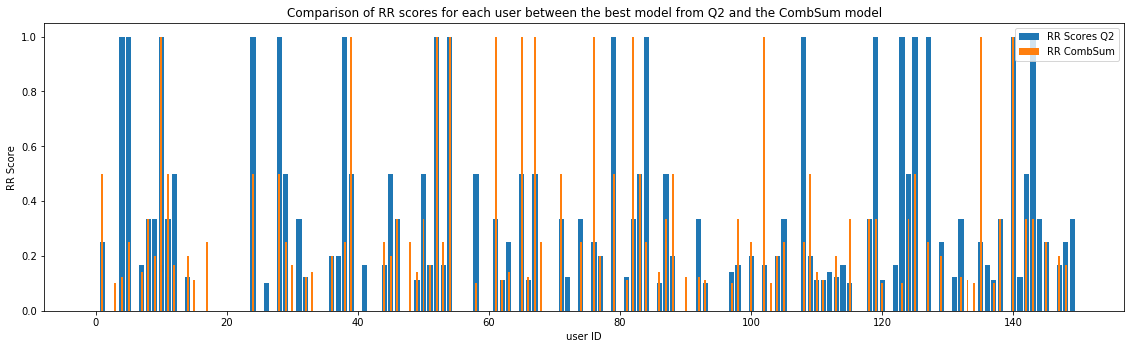

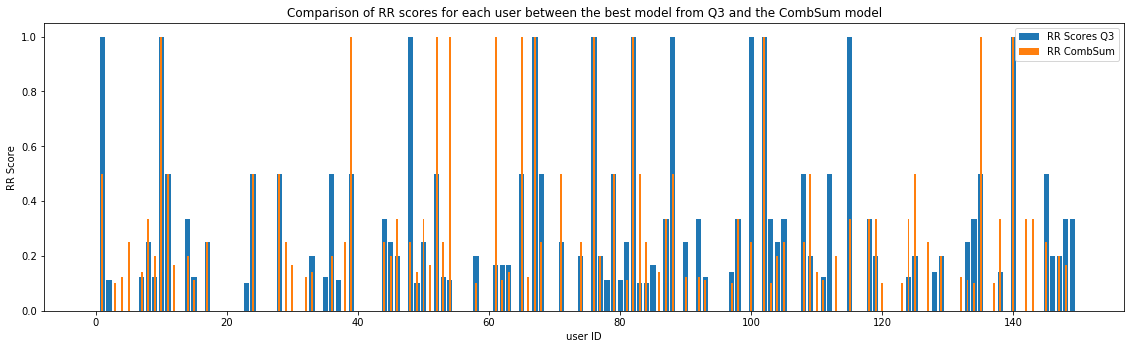

In [51]:
#We plot for the first 150 users otherwise the graph quickly becomes unreadable (or very wide).
nUsers = 150
idArray = np.arange(1999)
#plt.figure(figsize=(20,20))
ax1 = plt.axes([0, 0, 2.5, 1])
plt.title("Comparison of RR scores for each user between the best model from Q2 and the CombSum model")
# plt.plot(idArray[:100],RRScoresOne[:100],label="RR Scores Q2")
# plt.plot(idArray[:100],RRScoresCS[:100],label="RR CombSum")
plt.bar(idArray[:nUsers],RRScoresOne[:nUsers],label="RR Scores Q2")
plt.bar(idArray[:nUsers],RRScoresCS[:nUsers],label="RR CombSum",width=0.3)
plt.xlabel("user ID")
plt.ylabel("RR Score")


#axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([-10,10])
plt.legend()
plt.show()

#print(idArray)
#plt.figure(figsize=(20,20))
ax2 = plt.axes([0, 0, 2.5, 1])
plt.title("Comparison of RR scores for each user between the best model from Q3 and the CombSum model")
# plt.plot(idArray[:100],RRScoresTwo[:100],label="RR Scores Q3")
# plt.plot(idArray[:100],RRScoresCS[:100],label="RR CombSum")
plt.bar(idArray[:nUsers],RRScoresTwo[:nUsers],label="RR Scores Q3")
plt.bar(idArray[:nUsers],RRScoresCS[:nUsers],label="RR CombSum", width=0.3)
plt.xlabel("user ID")
plt.ylabel("RR Score")

#axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([-10,10])
plt.legend()
plt.show()
#print(idArray)

0.23098791459221674 0.2202132812437965 0.2278224429675155


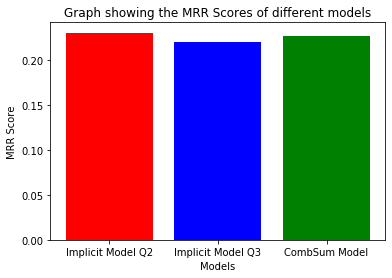

In [52]:
RRScoresOneMean = mrr_score(bestModelOne, test_dataset).mean()
#We trained our second best model using implicit data
RRScoresTwoMean = mrr_score(bestModelTwo, test_dataset).mean()
#We cannot specify training set for combSum
RRScoresCSMean = mrr_score(CSModel, test_dataset).mean()
print(RRScoresOneMean,RRScoresTwoMean,RRScoresCSMean)
results=[RRScoresOneMean,RRScoresTwoMean,RRScoresCSMean]
x = [1,2,3]
labels = ['Implicit Model Q2','Implicit Model Q3','CombSum Model']

fig, ax = plt.subplots()
plt.title("Graph showing the MRR Scores of different models")
ax.bar(x,results,color=['r','b','g'],label=labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel('Models')
plt.ylabel('MRR Score')

plt.show()

In [53]:
'''
Question 5
Develop a Lift-based recommender (see Lecture 4). Identify pairs of books rated positively by users in
ratings.csv (the order of being read does not matter, i.e. [x➙y] is equivalent to [y➙x]). Calculate
Lift for all pairs. Then develop a recommender where the score for each target recommended item is
the sum of the log log(lift)￼ between positively rated items in the user profile (rating ≥ 4) and the target
item. Do not score items that have already been rated by the user.
Implement a minimum Support Count threshold (see Lecture 4). In a graph, plot how MRR responds
to adjustments in the minimum Support Count threshold on the validation set. Identify the best support
threshold on the validation set and report the obtained performances on the test set.
Describe in your report how you performed calculations offline vs. online (i.e. within predict()
method). You may build upon the solution provided for Lab 1, but following University guidance, you
MUST acknowledge the source of any code you copy into your solution.
'''
def getCountPairs():
  #We find all positive ratings that are greater or equal to 4
  posRatings = ratings_df[ratings_df["rating"]>=4]
  allPairs = pd.merge(posRatings, posRatings, on=["user_id"])

  listPairs=allPairs[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()
  
  #This still includes pairs with duplicates
  countPairs = listPairs.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)
  return posRatings,countPairs


def sortStructTitles(withtitles):

  sortTitles = withtitles.sort_values(['lift'], ascending=False)

  sortTitles['log_lift'] = np.log(sortTitles['lift'])
  titlesLogLift = sortTitles.iloc[:, ~sortTitles.columns.duplicated()]

  titlesWithoutDups = titlesLogLift.drop(titlesLogLift[titlesLogLift['book_id_x']==titlesLogLift['book_id_y']].index)

  result = titlesWithoutDups[['book_id_x', 'book_id_y', 'count', 'log_lift']]

  return(result)

print("Table of all positive ratings:")
print(getCountPairs())

'''
        book_id_x  book_id_y  count
4728            4          4    528
0               1          1    502
36660          25         25    453
25867          18         18    414
10882           8          8    408
...           ...        ...    ...
244485        213         78      1
634174        786        961      1
634175        786        974      1
634176        786        975      1
539414        628        696      1
'''

Table of all positive ratings:
(        Unnamed: 0  user_id  book_id  rating
0                0        1      258       5
2             1998      143      258       4
3             4731      325      258       4
7             7702      473      258       4
8            11816      579      258       5
...            ...      ...      ...     ...
124755      438250     1067     1499       4
124756      438536      889     1499       5
124757      438735     1920     1499       4
124759      439505      927     1499       4
124760      439728     1298     1499       4

[80030 rows x 4 columns],         book_id_x  book_id_y  count
4728            4          4    528
0               1          1    502
36660          25         25    453
25867          18         18    414
10882           8          8    408
...           ...        ...    ...
244485        213         78      1
634174        786        961      1
634175        786        974      1
634176        786        975      1
53941

'\n        book_id_x  book_id_y  count\n4728            4          4    528\n0               1          1    502\n36660          25         25    453\n25867          18         18    414\n10882           8          8    408\n...           ...        ...    ...\n244485        213         78      1\n634174        786        961      1\n634175        786        974      1\n634176        786        975      1\n539414        628        696      1\n'

In [54]:
# Some code from the lab 1 solution Q7 was used for this part
# Solution

posRatings,countPairs = getCountPairs()
#We therefore need the counts of movies
movieCounts = posRatings.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

#lets puts all the information in the sample dataframe.
allstats = countPairs.merge(movieCounts, left_on="book_id_x", right_on="book_id").merge(movieCounts, left_on="book_id_y", right_on="book_id")

#and drop out some unused columns
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratingCount_x", "ratingCount_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#to calculate probabilites we need a denominator. I used the number of total ratings
num=float(ratings_df.count()["rating"])

#we can then perform artihmetic on columns
allstats["lift"] = (allstats["count"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))

#and finally, merge in the titles
withtitles = allstats.merge(books_df, left_on=["book_id_x"], right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")

#note that some of the movies with highlest lift have very low frequencies. We would apply a minium support threshold
sortWithTitles = sortStructTitles(withtitles)
print(sortWithTitles[['book_id_x', 'book_id_y', 'log_lift']])

#          book_id_x  book_id_y   log_lift
# 1078791       1416        418  11.734163
# 1070449       1608       1302  11.734163
# 1070448       1140       1302  11.734163
# 1078734        880       1227  11.734163
# 1035294       1811       1925  11.734163
# ...            ...        ...        ...
# 243430         248         61   1.553044
# 282728          19        112   1.435261
# 84399          112         19   1.435261
# 157342         297          6   1.273119
# 115357           6        297   1.273119

         book_id_x  book_id_y   log_lift
1078791       1416        418  11.734163
1070449       1608       1302  11.734163
1070448       1140       1302  11.734163
1078734        880       1227  11.734163
1035294       1811       1925  11.734163
...            ...        ...        ...
243430         248         61   1.553044
282728          19        112   1.435261
84399          112         19   1.435261
157342         297          6   1.273119
115357           6        297   1.273119

[1077014 rows x 3 columns]


In [55]:
'''
Then develop a recommender where the score for each target recommended item is
the sum of the log log(lift)￼ between positively rated items in the user profile (rating ≥ 4) and the target
item. Do not score items that have already been rated by the user.
'''
#Model is taking too long to run
class liftRecommender:
  
  def __init__(self, sortWithTitles):
    self.sortWithTitles = sortWithTitles
  
  def predict(self, uid):
    pred = []
    posRatedItems = list(ratings_df[(ratings_df['user_id']==uid) & (ratings_df['rating']>=4)]['book_id'])
    allRatedItems = list(ratings_df[(ratings_df['user_id']==uid)]['book_id'])
    allItems = books_df['book_id']

    #very inefficient - look into faster way
    for ID in allItems:
      #We select the log_lift for all pairs containing the target item, but not items that have already been rated by the user in book_id_y
      logLiftTarget = sortWithTitles[(sortWithTitles['book_id_x']==ID)&(~sortWithTitles['book_id_y'].isin(allRatedItems))]['log_lift']
      targetLiftSum = logLiftTarget.sum()
      pred += [targetLiftSum]

    return pred

#ISSUE - this step takes too long to make predictions
model = liftRecommender(sortWithTitles)
test = model.predict(1)
print(test)

'''
RESULTS:
[6810.85609573345, 6515.332391624992, ... , , 1194.671651227192, 2400.541124743631]
1993
'''

#print(idx)
#print(ratedBooks)
print(books_df['book_id'][1823])

[6810.85609573345, 6515.332391624992, 5588.544067829178, 6399.647998023565, 6133.312198685389, 5889.045157705828, 5870.687230548958, 5827.789545050162, 5726.820987762461, 6085.6751890574005, 6095.989415925089, 5808.725987002428, 5775.538938804924, 5657.463704933961, 5716.561077050337, 6260.334448672611, 6663.0119782346865, 6277.8579210513135, 5771.413877711073, 6555.638132005415, 6307.783235509125, 5600.094547099416, 6290.5074340520605, 6298.691876868674, 6515.435372023295, 5865.686317081972, 6339.27233763879, 5736.098595564053, 5606.250663582028, 6092.246498222143, 6007.198661081573, 5408.107473404456, 5802.589097766112, 2591.672939465898, 5288.899836261936, 5865.309397398478, 5895.684739170585, 5799.299454728228, 6051.847486011258, 4887.092275609064, 4953.797657653455, 5365.307631062131, 5703.309922316201, 3954.3987590778715, 5771.486820170849, 5898.539849479797, 5921.518237009092, 5377.602297880421, 5300.42109828073, 5628.965496892019, 3226.760846152292, 5384.368143683276, 3511.0478

In [56]:
'''
Question 6
In this question, we will combine the outputs of Questions 1, 2, 3 & 5 using a weighted CombSum score
combination method, to create a hybrid recommender system. In particular, please combine three
rankings selected from each of the following questions:
● Question 1 (pick at most one):
○ Average rating
○ Number of ratings
○ Number of 5* ratings
○ Fraction of 5* ratings
● Question 2 (pick at most one):
○ ExplicitFactorizationModel or ImplicitFactorizationModel on ratings
● Question 3:
○ ImplicitFactorizationModel on implicit data
● Question 5:
○ Your Lift-based recommender with best minimum Support threshold as identified on the
validation set.
Evaluate different combinations of weights for different score input features to find values that are the
most effective on your validation dataset. Report the final MRR performance on the test dataset.
'''

class weightedCombSumModel():

  def __init__(self, model1, model2, model3, weights):
    self.model1 = model1
    self.model2 = model2
    self.model3 = model3
    self.weights = weights

  def predict(self, uid):
    pred1 = self.weights[0] * np.array(self.model1.predict(uid))
    pred2 = self.weights[1] * np.array(self.model2.predict(uid))
    pred3 = self.weights[2] * np.array(self.model3.predict(uid))
    finalPred = pred1 + pred2 + pred3
    return finalPred


bestModelMetrics = baselineModel(fraction_5_ratings)

#There are more combinations but we do not try them all
weights = ([1/3,1/3,1/3],
           [8/10,1/10,1/10],[1/10,8/10,1/10],[1/10,1/10,8/10],
           [6/10,2/10,2/10],[2/10,6/10,2/10],[2/10,2/10,6/10],
           [4/10,3/10,3/10],[3/10,4/10,3/10],[3/10,3/10,4/10],
           [7/10,2/10,1/10],[7/10,1/10,2/10],[2/10,7/10,1/10],[1/10,7/10,2/10],[1/10,2/10,7/10],[2/10,1/10,7/10],
           [5/10,4/10,1/10],[5/10,1/10,4/10],[4/10,5/10,1/10],[1/10,5/10,4/10],[1/10,4/10,5/10],[4/10,1/10,5/10],
           [5/10,3/10,2/10],[5/10,2/10,3/10],[3/10,5/10,2/10],[2/10,5/10,3/10],[2/10,3/10,5/10],[3/10,2/10,5/10])



    
    
    
# [0.1,0.1,0.8], [0.1,0.8,0.1], [0.8,0.1,0.1], [0.4,0.3,0.3], [0.3,0.4,0.3], [0.3,0.3,0.4],
#        [0.2,0.3,0.5], [0.3,0.5,0.2], [0.5,0.2,0.3], [0.7,0.1,0.2], [0.2,0.7,0.1], [0.1,0.2,0.7])

bestScore = 0
bestWeights = list()
bestWeightedModel = None

#we find the optimal weight combination
for w in weights:
  currentModel = weightedCombSumModel(bestModelMetrics, bestModelOne, bestModelTwo, w)
  currentScore = mrr_score(currentModel, validation,train=toread_dataset_train).mean()
  if currentScore > bestScore:
    bestWeightedModel = currentModel
    bestScore = currentScore
    bestWeights = w

print ("The best score achieved by our hybrid model is: {}.\nThis score was achieved by combining models from Q1, Q2 and Q3\nThe respective combination of weights used is: {}".format(bestScore,bestWeights))

'''
RESULTS:
The best score achieved by our hybrid model is: 0.3207973034136115.
This score was achieved by combining models from Q1, Q2 and Q3
The respective combination of weights used is: [0.5, 0.3, 0.2]
'''

The best score achieved by our hybrid model is: 0.3207973034136115.
This score was achieved by combining models from Q1, Q2 and Q3
The respective combination of weights used is: [0.5, 0.3, 0.2]


'\nRESULTS:\nThe best score achieved by our hybrid model is: 0.3207973034136115.\nThis score was achieved by combining models from Q1, Q2 and Q3\nThe respective combination of weights used is: [0.5, 0.3, 0.2]\n'

Best Model Scores of each question:
Q1: 0.03138372904213526
Q2: 0.3276965863884323
Q3: 0.3376630775705313
Q6: 0.3528107307622065



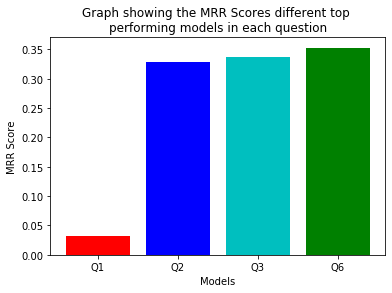

In [57]:
#We now test the model given our best result (and compare with previous results)
bestScoreQ1 = mrr_score(bestModelMetrics, test_dataset, train=rating_dataset, k=100).mean()
bestScoreQ2 = mrr_score(bestModelOne, test_dataset, train=train_dataset).mean()
bestScoreQ3 = mrr_score(bestModelTwo, test_dataset,train=toread_dataset_train).mean()
bestScoreQ6 = mrr_score(bestWeightedModel, test_dataset,train=toread_dataset_train).mean()

print("Best Model Scores of each question:\nQ1: {}\nQ2: {}\nQ3: {}\nQ6: {}\n".format(bestScoreQ1,bestScoreQ2,bestScoreQ3,bestScoreQ6))

results=[bestScoreQ1,bestScoreQ2,bestScoreQ3,bestScoreQ6]
x = [1,2,3,4]
labels = ['Q1','Q2','Q3','Q6']

fig, ax = plt.subplots()
plt.title("Graph showing the MRR Scores different top \nperforming models in each question")
ax.bar(x,results,color=['r','b','c','g'],label=labels)

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel('Models')
plt.ylabel('MRR Score')

plt.show()


In [58]:
'''
Question 7
Based on your experiments and the answers to all the questions above, write a few paragraphs making
suggestions for what a good recommender system deployment for this dataset, taking into account
both efficiency and effectiveness. Support your argument by referring to the obtained results and
graphs in questions 1-6. Moreover, reflect on what you have learned about recommender systems in
conducting this exercise
''' 
#Reflections written in the report.

'\nQuestion 7\nBased on your experiments and the answers to all the questions above, write a few paragraphs making\nsuggestions for what a good recommender system deployment for this dataset, taking into account\nboth efficiency and effectiveness. Support your argument by referring to the obtained results and\ngraphs in questions 1-6. Moreover, reflect on what you have learned about recommender systems in\nconducting this exercise\n'